In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [51]:
df = pd.read_csv("house_prices_srilanka.csv")
df.head()

,district,area,perch,bedrooms,bathrooms,kitchen_area_sqft,parking_spots,has_garden,has_ac,water_supply,electricity,floors,year_built,price_lkr
0,Polonnaruwa,Polonnaruwa Central,14,5,4,112,2,False,False,Pipe-borne,Single phase,1,2022,16236332
1,Matale,Matale Central,26,7,5,250,2,True,False,Both,Single phase,3,1987,33907509
2,Mullaitivu,Mullaitivu Central,7,3,2,77,2,True,True,Well,Single phase,1,1988,5954312
3,Anuradhapura,New Town,2,2,2,39,1,True,True,Both,Three phase,2,2024,5177534
4,Batticaloa,Batticaloa Town,20,5,4,117,1,True,True,Well,Single phase,1,1995,20182409


In [52]:
# Check for outliers
df.describe()

,perch,bedrooms,bathrooms,kitchen_area_sqft,parking_spots,floors,year_built,price_lkr
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,2.000000e+04
mean,11.510500,3.901600,3.171650,113.718800,1.141100,1.557150,2004.926550,1.598142e+07
std,8.519719,1.839426,1.530883,69.801873,0.939167,0.628135,11.817353,1.338156e+07
min,2.000000,1.000000,1.000000,35.000000,0.000000,1.000000,1985.000000,1.500000e+06
25%,5.000000,2.000000,2.000000,53.000000,0.000000,1.000000,1995.000000,6.591047e+06
50%,10.000000,4.000000,3.000000,95.000000,1.000000,1.000000,2005.000000,1.206384e+07
75%,16.000000,5.000000,5.000000,161.000000,2.000000,2.000000,2015.000000,2.096723e+07
max,80.000000,7.000000,5.000000,250.000000,3.000000,3.000000,2025.000000,1.500321e+08


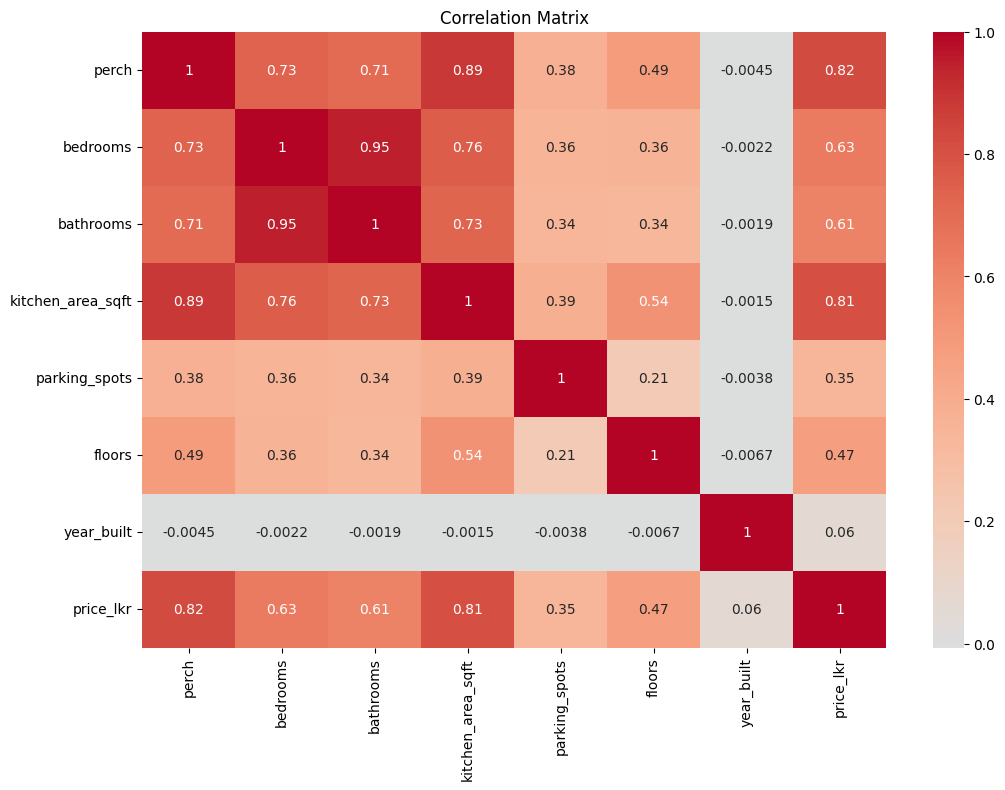

In [53]:
# Correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(df.select_dtypes(include=[np.number]).corr(),
            annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

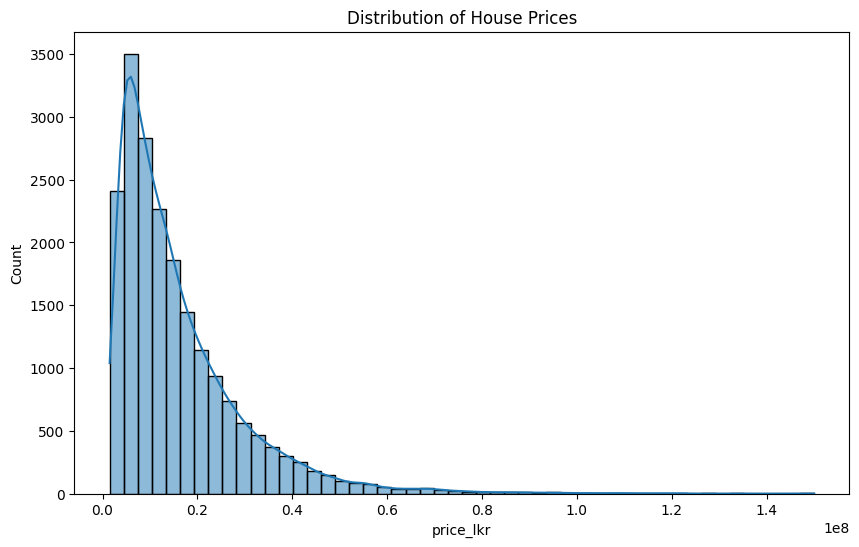

In [54]:
# Check target variable distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['price_lkr'], bins=50, kde=True)
plt.title('Distribution of House Prices')
plt.show()

In [55]:
print("Shape:", df.shape)
print("\nInfo:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())

Shape: (20000, 14)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   district           20000 non-null  object
 1   area               20000 non-null  object
 2   perch              20000 non-null  int64 
 3   bedrooms           20000 non-null  int64 
 4   bathrooms          20000 non-null  int64 
 5   kitchen_area_sqft  20000 non-null  int64 
 6   parking_spots      20000 non-null  int64 
 7   has_garden         20000 non-null  bool  
 8   has_ac             20000 non-null  bool  
 9   water_supply       20000 non-null  object
 10  electricity        20000 non-null  object
 11  floors             20000 non-null  int64 
 12  year_built         20000 non-null  int64 
 13  price_lkr          20000 non-null  int64 
dtypes: bool(2), int64(8), object(4)
memory usage: 1.9+ MB
None

Missing Values:
district             0
area     

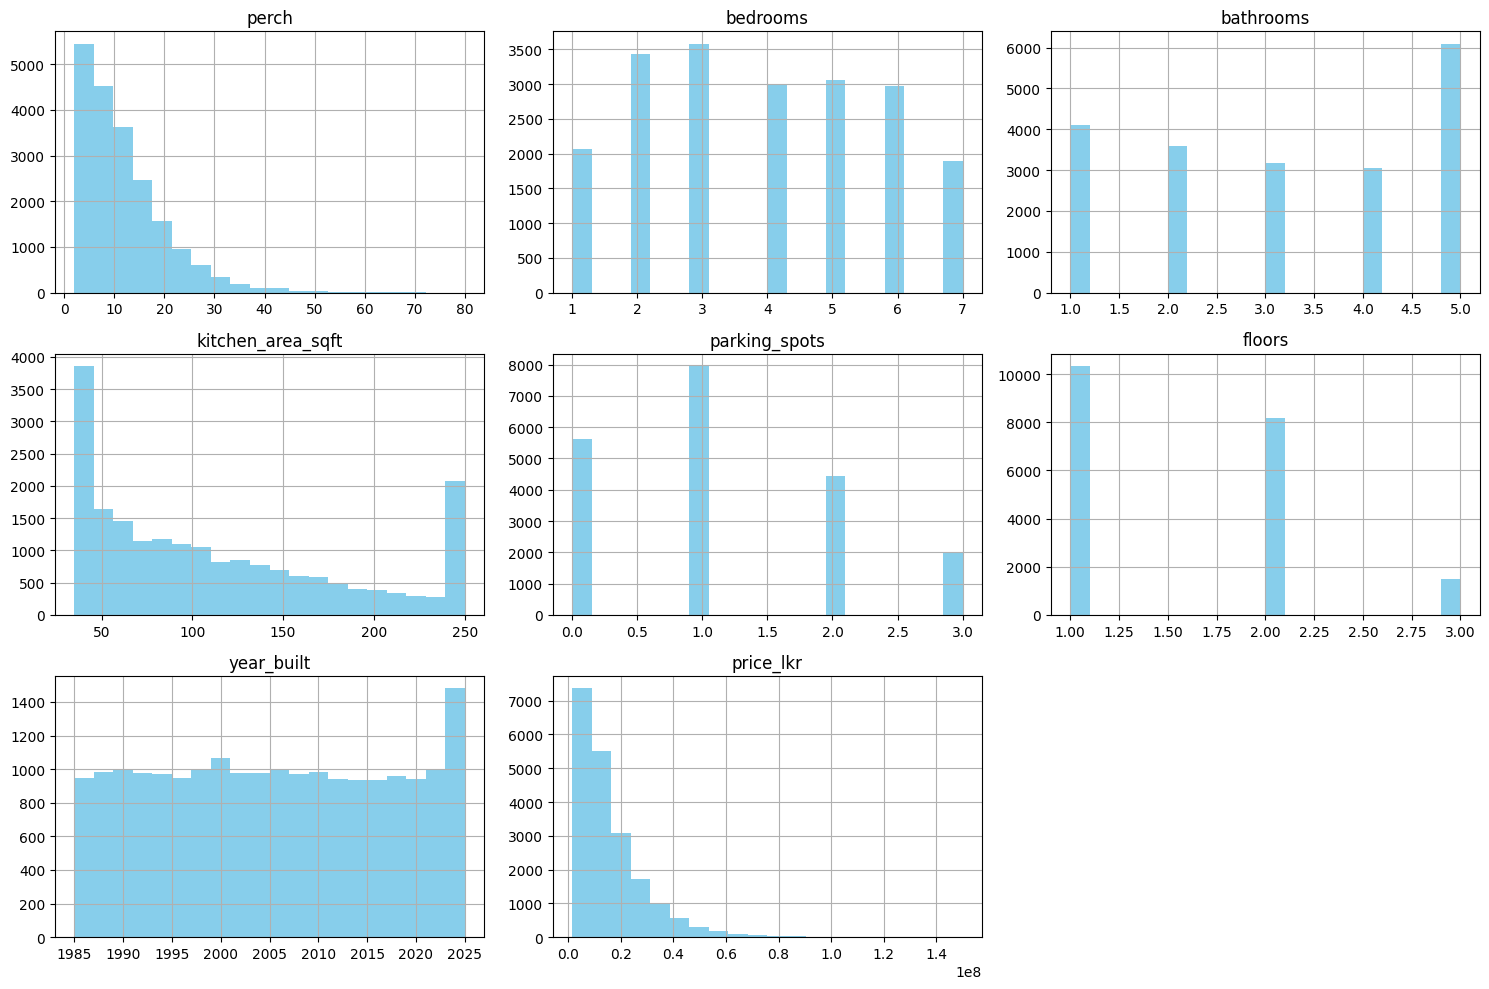

In [56]:
num_cols = ['perch','bedrooms','bathrooms','kitchen_area_sqft',
            'parking_spots','floors','year_built','price_lkr']

df[num_cols].hist(bins=20, figsize=(15,10), color='skyblue')
plt.tight_layout()
plt.show()

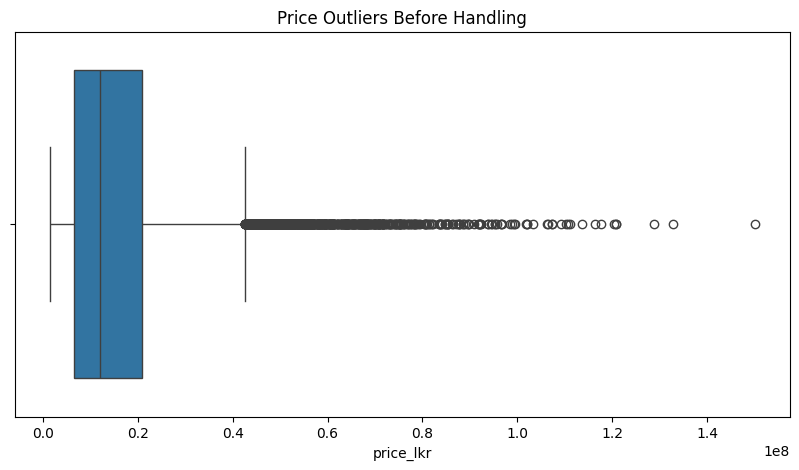

In [57]:
# Visualize outliers in price
plt.figure(figsize=(10, 5))
sns.boxplot(x=df['price_lkr'])
plt.title('Price Outliers Before Handling')
plt.show()

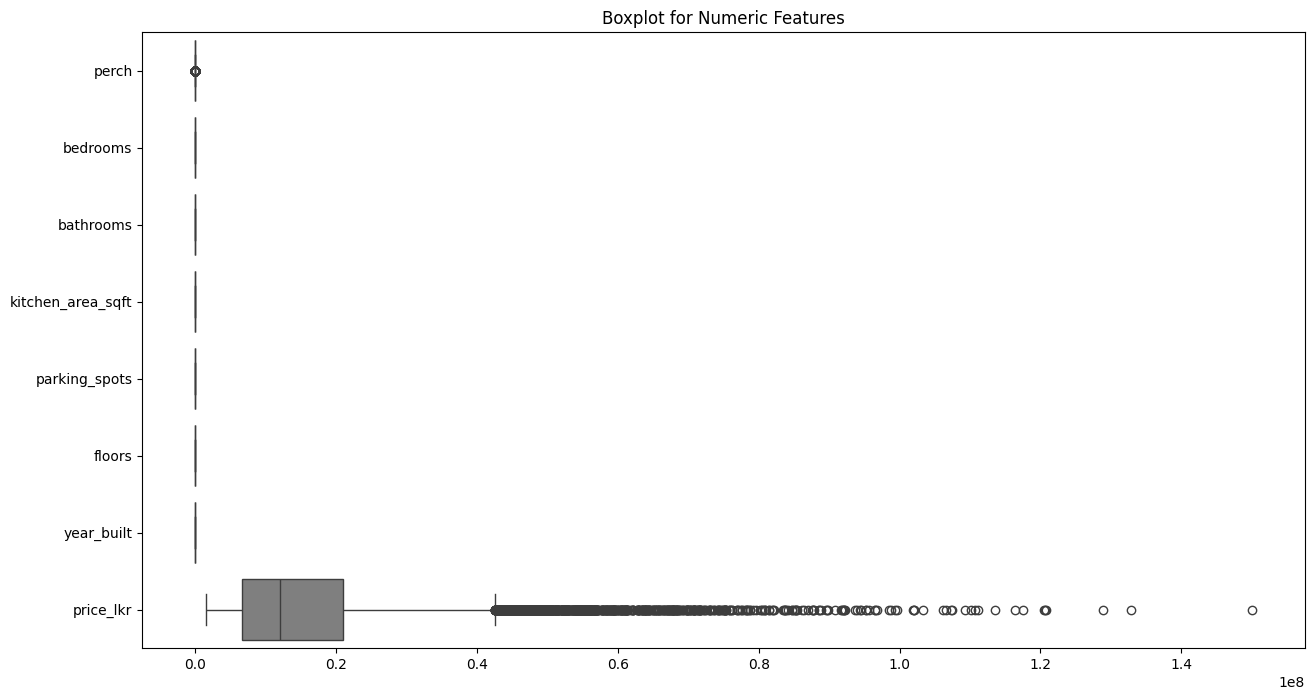

In [58]:
plt.figure(figsize=(15,8))
sns.boxplot(data=df[num_cols], orient='h')
plt.title("Boxplot for Numeric Features")
plt.show()

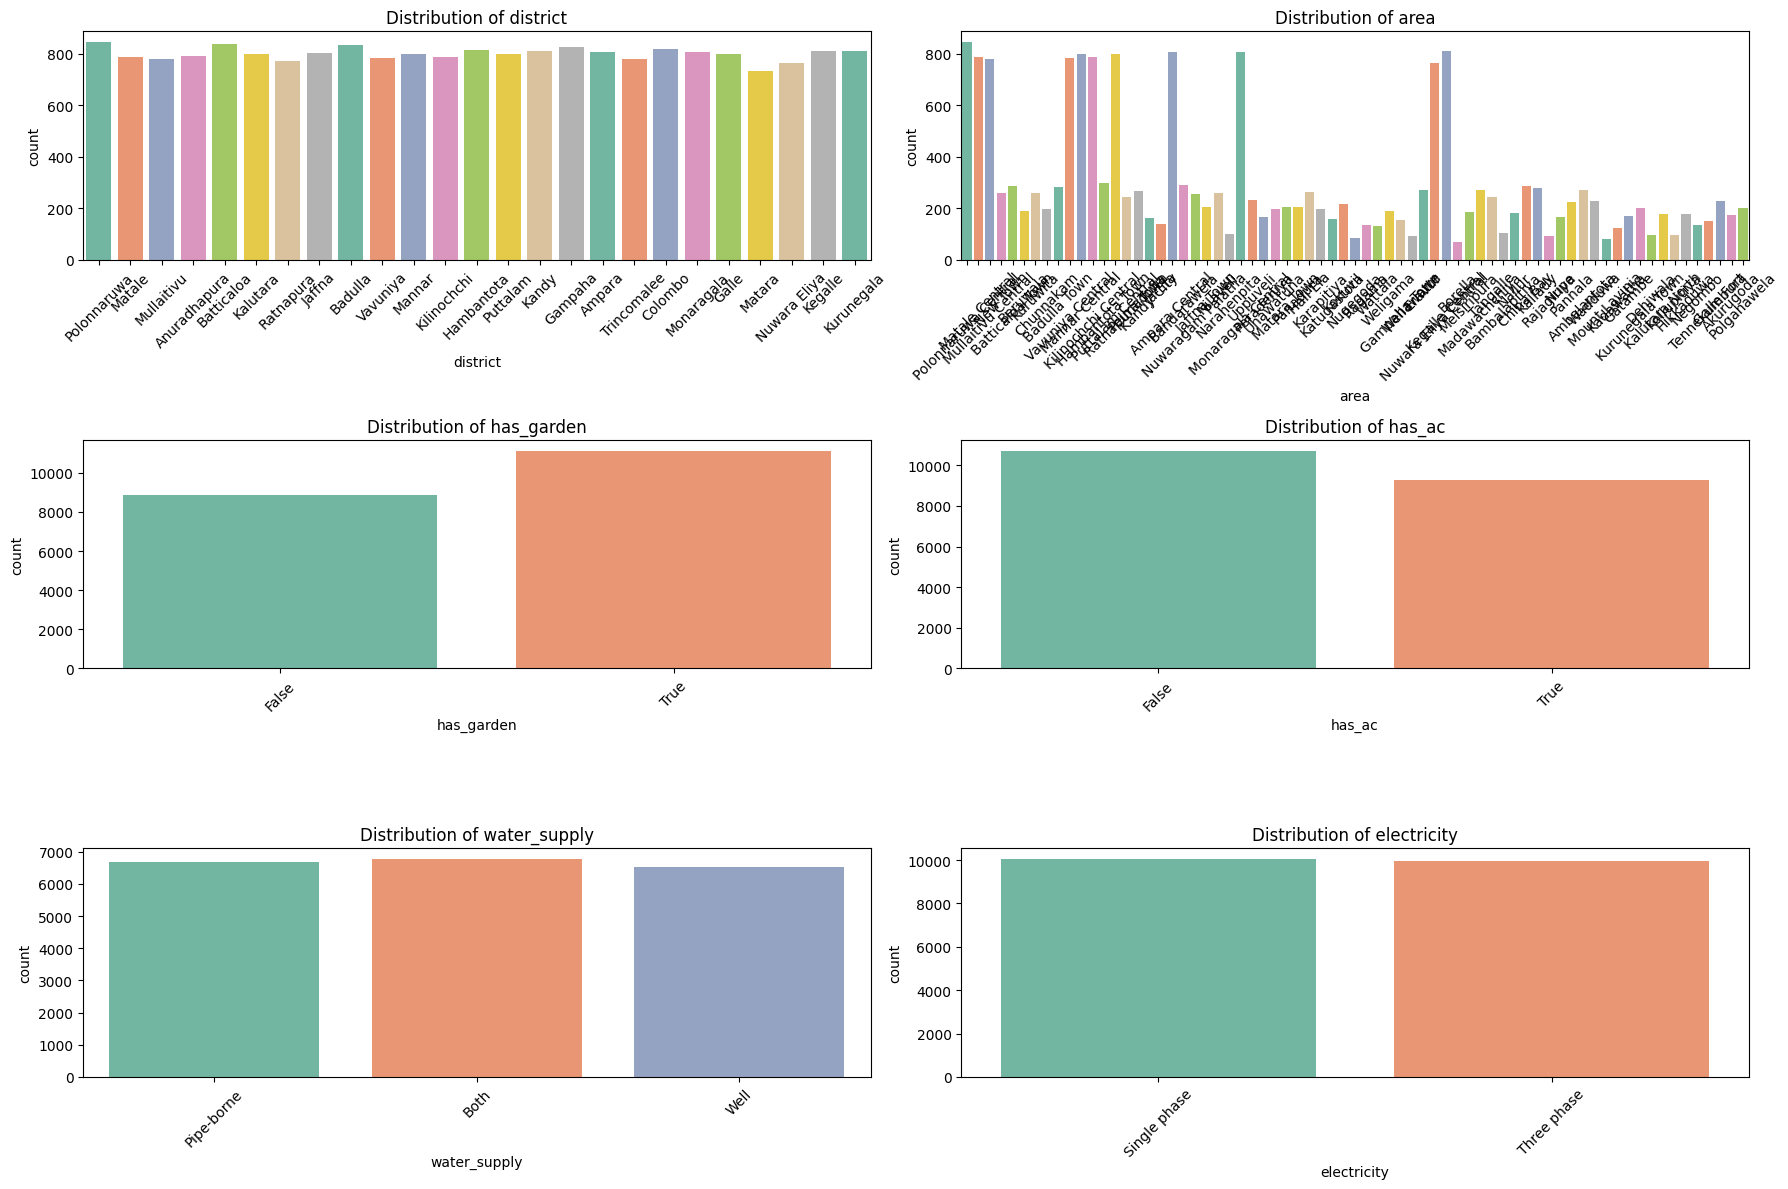

In [59]:
cat_cols = ['district', 'area', 'has_garden', 'has_ac',
            'water_supply', 'electricity']

plt.figure(figsize=(18,12))
for i, col in enumerate(cat_cols, 1):
    plt.subplot(3, 2, i)
    sns.countplot(x=col, data=df, palette="Set2", hue=col, legend=False)
    plt.xticks(rotation=45)
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

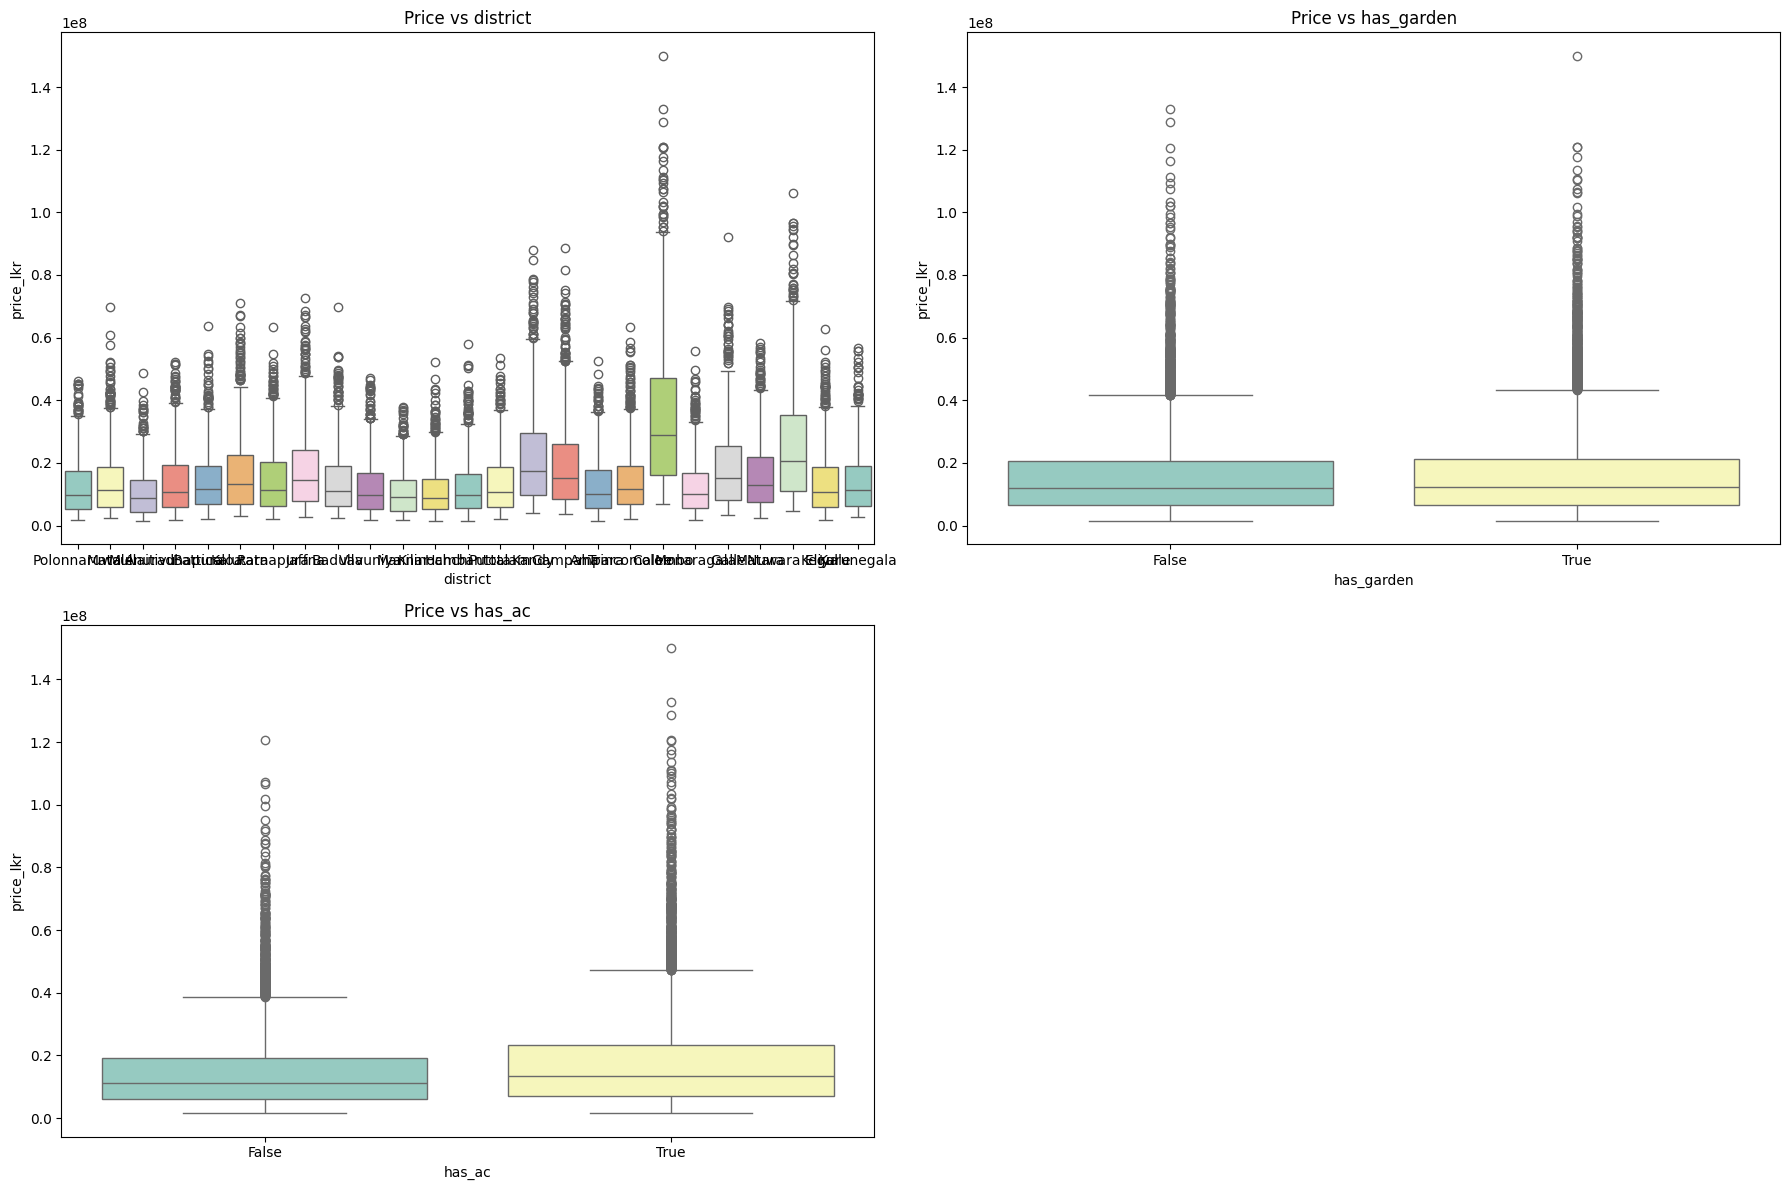

In [60]:
plt.figure(figsize=(18,12))
for i, col in enumerate(['district', 'has_garden', 'has_ac'], 1):
    plt.subplot(2,2,i)
    sns.boxplot(x=col, y='price_lkr', data=df, palette="Set3", hue=col, legend=False)
    plt.title(f"Price vs {col}")
plt.tight_layout()
plt.show()

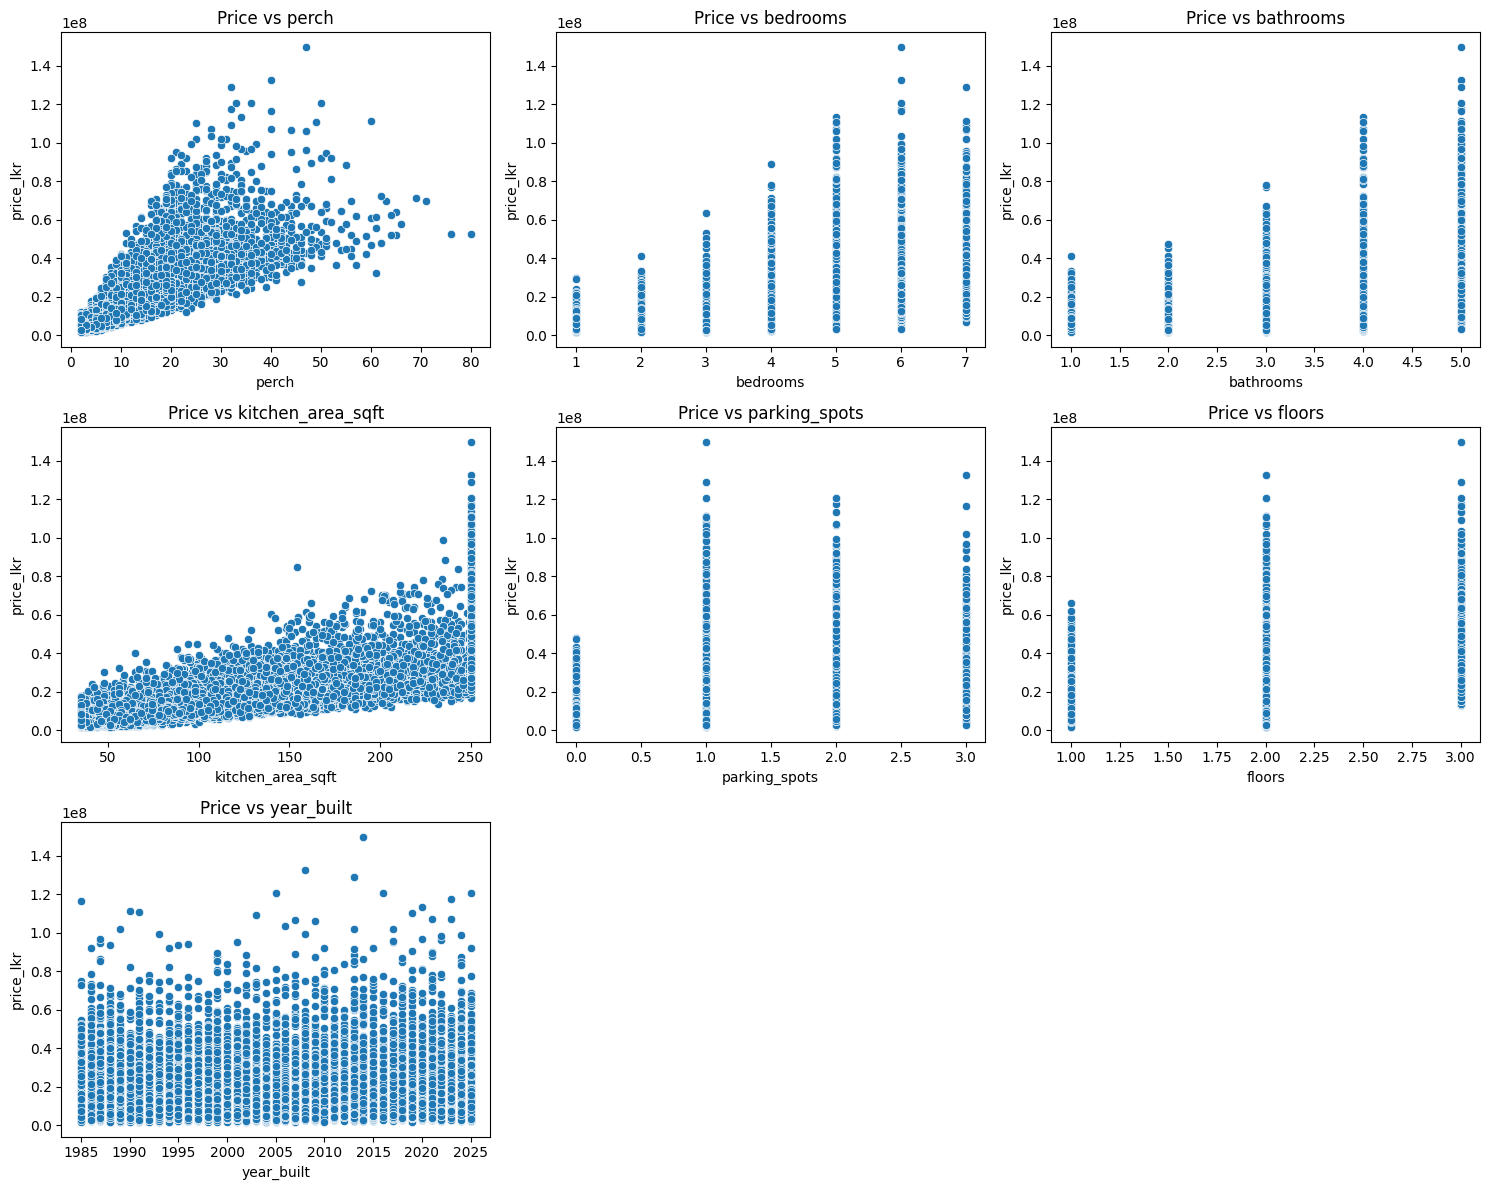

In [61]:
plt.figure(figsize=(15,12))
for i, col in enumerate(['perch','bedrooms','bathrooms','kitchen_area_sqft',
                         'parking_spots','floors','year_built'], 1):
    plt.subplot(3,3,i)
    sns.scatterplot(x=col, y='price_lkr', data=df)
    plt.title(f"Price vs {col}")
plt.tight_layout()
plt.show()

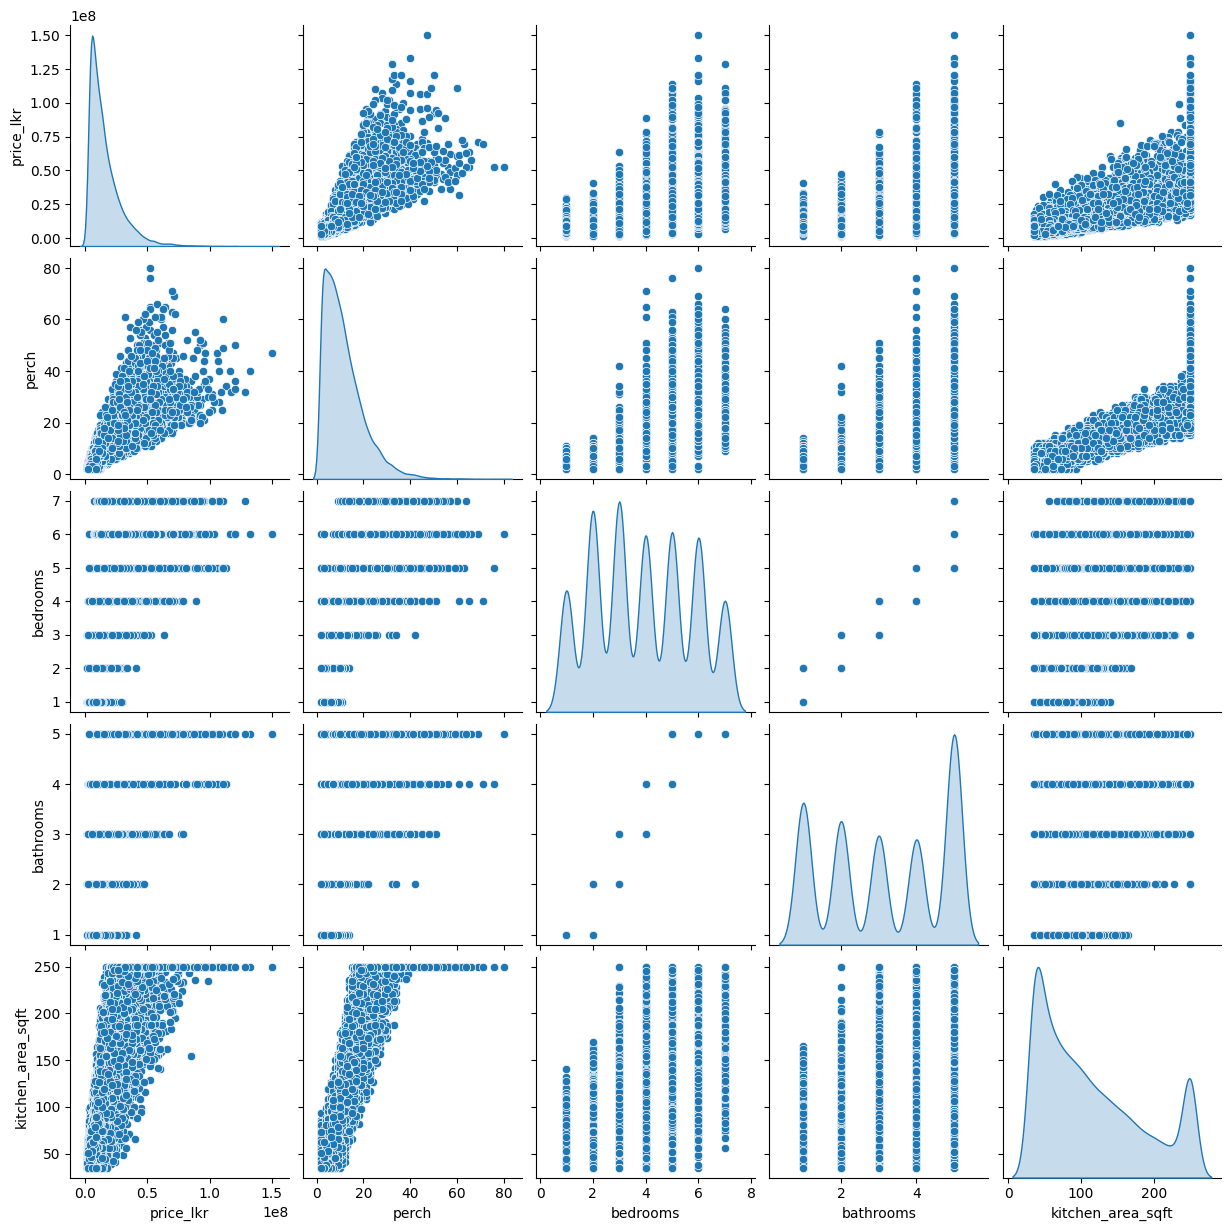

In [62]:
sns.pairplot(df[['price_lkr','perch','bedrooms','bathrooms','kitchen_area_sqft']],
             kind='scatter', diag_kind='kde')
plt.show()

In [63]:
print("Shape:", df.shape)
print("\nInfo:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())

Shape: (20000, 14)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   district           20000 non-null  object
 1   area               20000 non-null  object
 2   perch              20000 non-null  int64 
 3   bedrooms           20000 non-null  int64 
 4   bathrooms          20000 non-null  int64 
 5   kitchen_area_sqft  20000 non-null  int64 
 6   parking_spots      20000 non-null  int64 
 7   has_garden         20000 non-null  bool  
 8   has_ac             20000 non-null  bool  
 9   water_supply       20000 non-null  object
 10  electricity        20000 non-null  object
 11  floors             20000 non-null  int64 
 12  year_built         20000 non-null  int64 
 13  price_lkr          20000 non-null  int64 
dtypes: bool(2), int64(8), object(4)
memory usage: 1.9+ MB
None

Missing Values:
district             0
area     

In [64]:
df['has_garden'] = df['has_garden'].map({True:1, False:0})
df['has_ac'] = df['has_ac'].map({True:1, False:0})

In [65]:
df.head()

,district,area,perch,bedrooms,bathrooms,kitchen_area_sqft,parking_spots,has_garden,has_ac,water_supply,electricity,floors,year_built,price_lkr
0,Polonnaruwa,Polonnaruwa Central,14,5,4,112,2,0,0,Pipe-borne,Single phase,1,2022,16236332
1,Matale,Matale Central,26,7,5,250,2,1,0,Both,Single phase,3,1987,33907509
2,Mullaitivu,Mullaitivu Central,7,3,2,77,2,1,1,Well,Single phase,1,1988,5954312
3,Anuradhapura,New Town,2,2,2,39,1,1,1,Both,Three phase,2,2024,5177534
4,Batticaloa,Batticaloa Town,20,5,4,117,1,1,1,Well,Single phase,1,1995,20182409


In [66]:
import datetime

if 'year_built' in df.columns:
    df['house_age'] = datetime.datetime.now().year - df['year_built']
    df.drop(columns=['year_built'], inplace=True)
else:
    print("Column 'year_built' not found. It might have been processed already.")

In [67]:
df.head()

,district,area,perch,bedrooms,bathrooms,kitchen_area_sqft,parking_spots,has_garden,has_ac,water_supply,electricity,floors,price_lkr,house_age
0,Polonnaruwa,Polonnaruwa Central,14,5,4,112,2,0,0,Pipe-borne,Single phase,1,16236332,4
1,Matale,Matale Central,26,7,5,250,2,1,0,Both,Single phase,3,33907509,39
2,Mullaitivu,Mullaitivu Central,7,3,2,77,2,1,1,Well,Single phase,1,5954312,38
3,Anuradhapura,New Town,2,2,2,39,1,1,1,Both,Three phase,2,5177534,2
4,Batticaloa,Batticaloa Town,20,5,4,117,1,1,1,Well,Single phase,1,20182409,31


In [68]:
df = pd.get_dummies(df, drop_first=True)

In [69]:
df.head()

,perch,bedrooms,bathrooms,kitchen_area_sqft,parking_spots,has_garden,has_ac,floors,price_lkr,house_age,...,area_Unawatuna,area_Uppuveli,area_Vavuniya Central,area_Wadduwa,area_Wattala,area_Weligama,area_Wellawatte,water_supply_Pipe-borne,water_supply_Well,electricity_Three phase
0,14,5,4,112,2,0,0,1,16236332,4,...,False,False,False,False,False,False,False,True,False,False
1,26,7,5,250,2,1,0,3,33907509,39,...,False,False,False,False,False,False,False,False,False,False
2,7,3,2,77,2,1,1,1,5954312,38,...,False,False,False,False,False,False,False,False,True,False
3,2,2,2,39,1,1,1,2,5177534,2,...,False,False,False,False,False,False,False,False,False,True
4,20,5,4,117,1,1,1,1,20182409,31,...,False,False,False,False,False,False,False,False,True,False


In [70]:
from sklearn.model_selection import train_test_split

X = df.drop("price_lkr", axis=1)
y = df["price_lkr"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

In [71]:
pip install xgboost

In [72]:
from xgboost import XGBRegressor

model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

In [73]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("RMSE:", rmse)
print("MAE:", mae)
print("R2 Score:", r2)

RMSE: 2443479.8630543286
MAE: 1613447.625
R2 Score: 0.9664371609687805


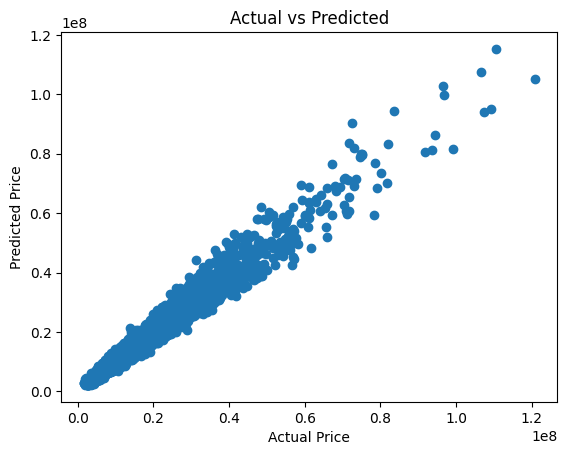

In [74]:
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted")
plt.show()

In [75]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'n_estimators': [300, 500, 700],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9]
}

search = RandomizedSearchCV(
    XGBRegressor(random_state=42),
    param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    n_iter=10,
    verbose=1
)

search.fit(X_train, y_train)

best_model = search.best_estimator_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [76]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("RMSE:", rmse)
print("MAE:", mae)
print("R2 Score:", r2)

RMSE: 2443479.8630543286
MAE: 1613447.625
R2 Score: 0.9664371609687805


In [77]:
pip install shap

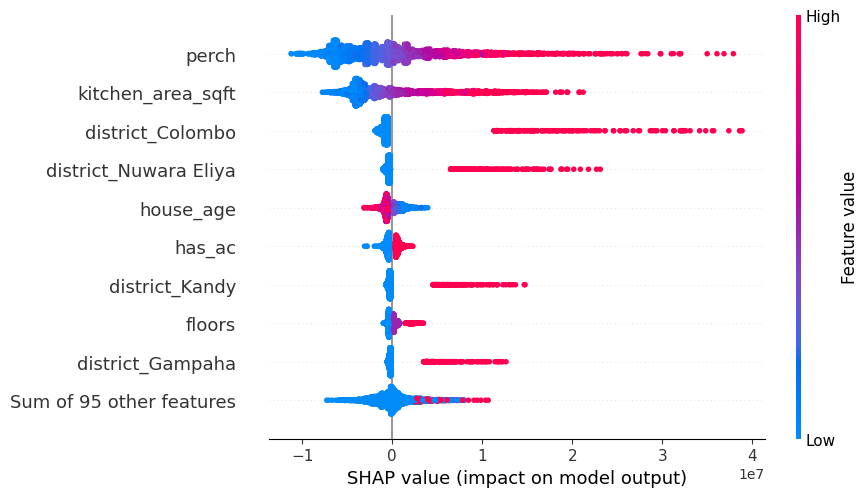

In [78]:
import shap

explainer = shap.Explainer(best_model)
shap_values = explainer(X_test)

shap.plots.beeswarm(shap_values)

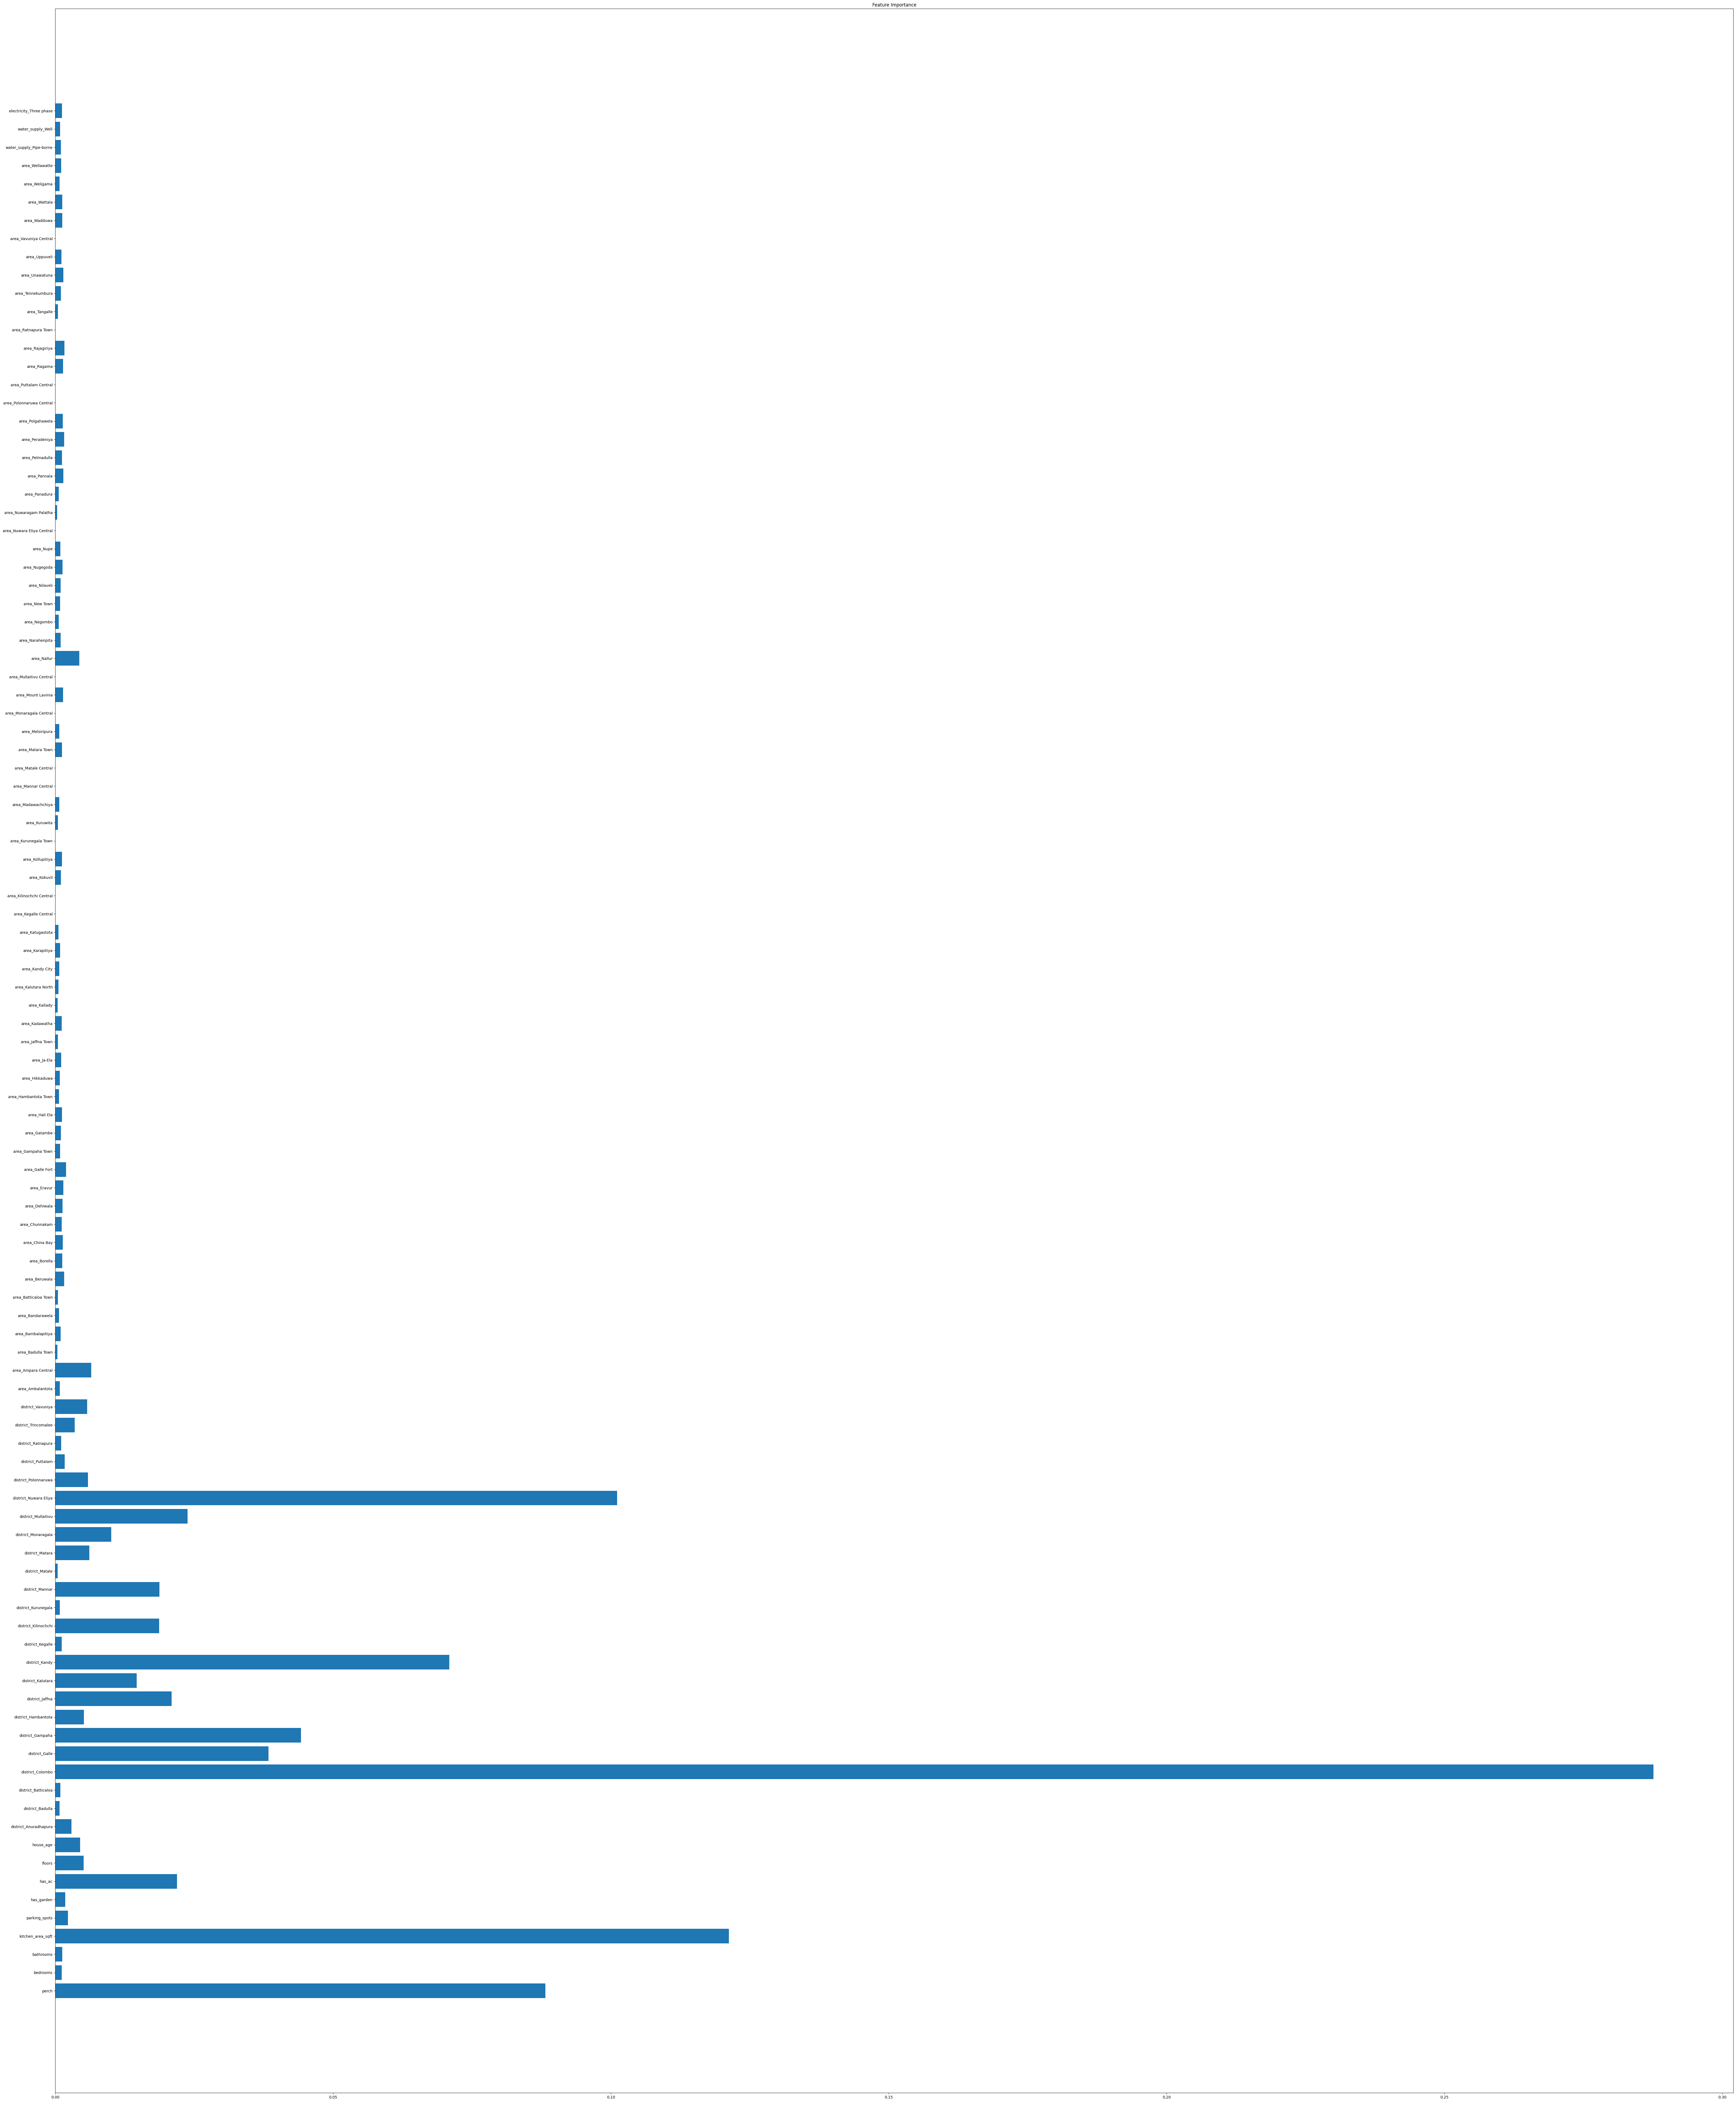

In [81]:
import matplotlib.pyplot as plt

importances = best_model.feature_importances_
features = X.columns

plt.figure(figsize=(80,100))
plt.barh(features, importances)
plt.title("Feature Importance")
plt.show()

In [82]:
# Save the tuned XGBoost model
best_model.save_model("house_price_model.json")